installation des bibliotheques utilisées

In [3]:
!pip install nltk
!pip install networkx
!pip install pytextrank
!python -m spacy download en_core_web_sm
!pip list | grep pytextrank

2023-08-16 14:29:27.919832: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-16 14:29:29.147145: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 25.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
pytextrank                       3.2.5


In [4]:
import spacy
import pytextrank
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe("textrank")

charger notre dataset(validation+test)

In [5]:
import pandas as pd
data_label_1 = pd.read_csv('labeled_2023_04_28.csv')
data_label_2 = pd.read_csv('labeled_2023_05_08_version_final.csv')
df = pd.concat([data_label_1, data_label_2], ignore_index=True)
df.head()

,Unnamed: 0,id,lang,isDuplicate,date,time,dateTime,dateTimePub,dataType,sim,...,createdAt,country,location,translated,translated_body,translated_title,clean_text,is_relevant,importance_score,label
0,0,7095357446,eng,False,2022-06-28,20:25:00,2022-06-28T20:25:00Z,2022-06-28T20:25:00Z,news,0.866667,...,2022-06-28T20:47:00Z,NaN,NaN,False,NaN,NaN,by jessica damiano associated press\n\nthe co...,False,NaN,NaN
1,1,7100315028,eng,False,2022-07-02,16:49:00,2022-07-02T16:49:00Z,2022-07-02T16:48:00Z,news,0.937255,...,2022-07-02T17:07:00Z,NaN,NaN,False,NaN,NaN,the cost of everything from gas to burgers may...,False,NaN,NaN
2,2,7095328304,eng,False,2022-06-28,19:51:00,2022-06-28T19:51:00Z,2022-06-28T19:50:00Z,news,0.901961,...,2022-06-28T20:47:00Z,NaN,NaN,False,NaN,NaN,by jessica damiano associated press\n\nthe co...,False,NaN,NaN
3,3,7095562326,eng,False,2022-06-29,01:33:00,2022-06-29T01:33:00Z,2022-06-29T01:32:00Z,news,0.894118,...,2022-06-29T03:07:00Z,NaN,NaN,False,NaN,NaN,by jessica damiano associated press\n\nthe co...,False,NaN,NaN
4,4,b-7131974343,eng,False,2022-07-29,02:42:00,2022-07-29T02:42:00Z,2022-07-29T02:42:00Z,blog,NaN,...,2022-07-29T03:07:00Z,NaN,NaN,False,NaN,NaN,the th edition of india foodex will be held f...,False,NaN,NaN


In [6]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

cleaning text (colonne body)

In [7]:
def cleaned_text(text):
    clean = re.sub("\n"," ",text)
    clean=clean.lower()
    clean=re.sub(r"[~.,%/:;?_&+*=!-]"," ",clean)
    clean=re.sub("[^a-z]"," ",clean)
    clean=clean.lstrip()
    clean=re.sub("\s{2,}"," ",clean)
    return clean
df["cleaned_paper_text"]=df["body"].apply(cleaned_text)

In [8]:
df["cleaned_paper_text"] = df["cleaned_paper_text"].apply(lambda x: ' '.join([word for word in x.split() if len(word)>3]))

In [9]:
stop=stopwords.words('english')
stop.append("also")
df["stop_removed_paper_text"]=df["cleaned_paper_text"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [10]:
df["tokenized"]=df["stop_removed_paper_text"].apply(lambda x: nltk.word_tokenize(x))

In [11]:
from nltk.stem import WordNetLemmatizer
def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i,pos='v') for i in text]
    return lem_text
df["lemmatized"]=df["tokenized"].apply(lambda x: word_lemmatizer(x))
df["Body"]=df["lemmatized"].apply(lambda x: ' '.join(x))

agrici_concepts_stemmed

In [12]:
from nltk.stem import PorterStemmer

def stem_words(word_list):
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in word_list]
    return stemmed_words

In [13]:
agri_keywords_en = ['brazil', 'argentine', 'USA', 'italy', 'germany', 'spain', 'poland', 'perception', 'soil', 'pollen', 'traders', 'tender', 'tassel corn', 'supply', 'demand', 'planting', 'flowering', 'tomatoes', 'lutte', 'green', 'expansion', 'companies', 'corn', 'corps', 'planting', 'agriculture', 'farming', 'harvest', 'ags', 'cotton', 'COVID-19', 'soil health', 'irrigation systems', 'pest management', 'monsoon', 'agrochemical', 'rice', 'crop', 'drought', 'rainfall', 'food', 'pandemic', 'climatologist', 'farm', 'farmer', 'broccoli', 'cucumbers', 'squash', 'lettuce', 'beans', 'peppers', 'basil', 'eggplant', 'csa program', 'farms', 'plant nutrient', 'wheat', 'agricultural', 'moringa products', 'packaging', 'distribution', 'health benefits', 'growth', 'vendors', 'growth prospects', 'fast-growing segments', 'slow-growing segments', 'moringa seeds', 'oil', 'healthcare', 'personal care product industries', 'therapeutic potential', 'disposable incomes', 'exports', 'Offerings', 'market definition', 'market size', 'forecast', 'year-over-year growth', 'COVID-19 pandemic', 'price sensitivity', 'adoption lifecycle', 'price', 'Key purchase criteria', 'Growing demand', 'vegan demographics', 'vendor overview', 'product segments', 'farm technology', 'tractor', 'farm management', 'Production', 'soybeans', 'sugar', 'USDA', 'Biopesticides', 'organic agriculture', 'Marrone Bio Innovations', 'bioinsecticides', 'biofungicides', 'Bionematicides', 'Bioherbicides', 'fruits', 'vegetables', 'specialty crops', 'botanical', 'bacillus', 'trichoderma', 'streptomyces', 'institutional investors', 'COVID', 'ukrain', 'russia', 'war', 'cereals', 'season', 'seeds', 'yields', 'renewables', 'nutrient', 'grow', 'biopesticides', 'market', 'investment', 'stocknews', 'stock', 'trading', 'rating', 'chief', 'service', 'economic', 'statement', 'painfully', 'first', 'fresh', 'indonesia', 'say', 'bring', 'company', 'outbreak', 'record', 'private', 'sioux', 'russian', 'economist', 'health', 'look', 'tree', 'line', 'register', 'be', 'turkey', 'study', 'gold', 'analysis', 'practice', 'finance', 'would', 'apiary', 'canada', 'project', 'hormel', 'phosphorus', 'european', 'trend', 'intermediary', 'pose', 'remain', 'dividend', 'recycle', 'ukraine', 'compostable', 'ghana', 'pembina', 'disease', 'nutrien', 'change', 'million', 'compare', 'high', 'take', 'temperature', 'escalator', 'major', 'fruit', 'lakh', 'military', 'barchart', 'commodity', 'country', 'rural', 'reference', 'local', 'continue', 'daily', 'mexico', 'solution', 'segment', 'mike', 'go', 'fertilizer', 'year', 'quarter', 'talk', 'forward', 'share', 'deal', 'acreage', 'income', 'iaea', 'people', 'climate', 'marketsandmarkets', 'cola', 'moringa', 'energy', 'univar', 'clash', 'europe', 'rat', 'cent', 'weapon', 'ukrainian', 'data', 'week', 'sow', 'exhibit', 'product', 'pest', 'ship', 'grain', 'production', 'government', 'arm', 'progress', 'insect', 'organic', 'bloomberg', 'china']
agri_keywords_en_stemmed = stem_words(agri_keywords_en)

charger pre-trained word embeddings

In [14]:
import pandas as pd
import numpy as np
import gensim.downloader as api
model = api.load("glove-wiki-gigaword-100")


textrank algo

In [15]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.probability import FreqDist
import string
import networkx as nx

def textrank(text, top_n):
    # Tokenize the text into sentences
    sentences = sent_tokenize(text)

    # Tokenize each sentence into words and remove punctuation
    words = [word.lower() for sentence in sentences for word in word_tokenize(sentence) if word not in string.punctuation]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    # Calculate word frequencies
    word_frequencies = FreqDist(words)

    # Build the graph representation
    graph = nx.Graph()
    graph.add_nodes_from(set(words))

    # Create edges between words based on co-occurrence
    for sentence in sentences:
        sentence_words = [lemmatizer.lemmatize(word.lower()) for word in word_tokenize(sentence) if word not in string.punctuation]
        for i in range(len(sentence_words)):
            for j in range(i + 1, len(sentence_words)):
                if graph.has_edge(sentence_words[i], sentence_words[j]):
                    graph[sentence_words[i]][sentence_words[j]]['weight'] += 1
                else:
                    graph.add_edge(sentence_words[i], sentence_words[j], weight=1)

    # Calculate the PageRank scores
    scores = nx.pagerank(graph)

    # Sort the words based on their scores
    sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)

    # Get the top N keywords
    keywords = [word for word, score in sorted_scores[:top_n]]
    return keywords

function ***score***

In [35]:
from sklearn.metrics.pairwise import cosine_similarity

def Score(row, agri_keywords_en_stemmed):
    # Preprocess the title
    title = row["title"]
    title_keywords = textrank(title, 5)
    title_stemmed_keywords = stem_words(title_keywords)
    title_vectors = [model[word] for word in title_stemmed_keywords if word in model]

    doc = nlp(row["Body"])
    sentences = []
    for sent in doc._.textrank.summary(limit_phrases=5, limit_sentences=5):
        sentences.append(sent.text)

    summary = ' '.join(sentences)
    body_keywords = textrank(summary, 10)
    body_stemmed_keywords = stem_words(body_keywords)
    body_vectors = [model[word] for word in body_stemmed_keywords if word in model]


    if title_vectors and body_vectors:
        title_score = np.mean(title_vectors, axis=0)
        body_score = np.mean(body_vectors, axis=0)
    else:
        title_score = np.zeros(model.vector_size)
        body_score = np.zeros(model.vector_size)
    agri_keywords_vectors = [model[word] for word in agri_keywords_en_stemmed if word in model]
    all_zeros = np.any(title_score == 0) or np.any(body_score == 0) or np.any(np.array(agri_keywords_vectors) == 0)

    similarity_scores = []
    if all_zeros:
        similarity_scores = [-1.0] * len(agri_keywords_en_stemmed)
    else:
        for agri_vector in agri_keywords_vectors:
            # Calculer cosine similarity between title and agri keywords
            title_similarity_score = cosine_similarity([title_score], [agri_vector])[0][0]
            # Calculer cosine similarity between body and agri keywords
            body_similarity_score = cosine_similarity([body_score], [agri_vector])[0][0]
            # moyenne entre les deux
            similarity_score = title_similarity_score * 0.3 + body_similarity_score * 0.6
            similarity_scores.append(similarity_score)

    average_similarity = np.mean(similarity_scores)

    return average_similarity


In [36]:
individual_scores = df.apply(lambda row: Score(row, agri_keywords_en_stemmed), axis=1)

In [37]:
df['scores'] = individual_scores

In [38]:
relevant_rows = df[df['is_relevant'] == True]
relevant_rows[['scores', 'is_relevant']]

,scores,is_relevant
8,0.324882,True
10,0.230234,True
11,0.299850,True
12,0.318239,True
13,0.279877,True
15,0.305745,True
16,0.273709,True
17,0.315608,True
18,0.281603,True
19,0.299253,True


In [48]:
import numpy as np

df["label"] = np.where(df["scores"] >= 0.255, True, False)

In [27]:
import pip
pip.main(['install','seaborn'])

/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Requirement already satisfied: seaborn in /usr/local/lib/python3.10/dist-packages (0.12.2)

Requirement already satisfied: numpy!=1.24.0,>=1.17 in /usr/local/lib/python3.10/dist-packages (from seaborn) (1.23.5)

Requirement already satisfied: pandas>=0.25 in /usr/local/lib/python3.10/dist-packages (from seaborn) (1.5.3)

Requirement already satisfied: matplotlib!=3.6.1,>=3.1 in /usr/local/lib/python3.10/dist-packages (from seaborn) (3.7.1)

Requirement already satisfied: contourpy>=1.0.1 in /usr/local/lib/python3.10/dist-packages (from matplotlib!=3.6.1,>=3.1->seaborn) (1.1.0)

Requirement already satisfied: cycler>=0.10 in /usr/local/lib/python3.10/dist-packages (from matplotlib!=3.6.1,>=3.1->seaborn) (0.11.0)

Requirement already satisfied: fonttools>=4.22.0 in /usr/local/lib/python3.10/dist-packages (from matplotlib!=3.6.1,>=3.1->seaborn) (4.42.0)

Requirement already satisfied: kiwisolver>=1.0.1 in /usr/local/lib/python3.10/dist-packages (from matplotlib!=3.6.1,>=3.1->seaborn) (1.4.4)

Requirement already satisfied: packaging>=20.0 in /usr/local/lib/python3.10/dist-packages (from matplotlib!=3.6.1,>=3.1->seaborn) (23.1)

Requirement already satisfied: pillow>=6.2.0 in /usr/local/lib/python3.10/dist-packages (from matplotlib!=3.6.1,>=3.1->seaborn) (9.4.0)

Requirement already satisfied: pyparsing>=2.3.1 in /usr/local/lib/python3.10/dist-packages (from matplotlib!=3.6.1,>=3.1->seaborn) (3.1.1)

Requirement already satisfied: python-dateutil>=2.7 in /usr/local/lib/python3.10/dist-packages (from matplotlib!=3.6.1,>=3.1->seaborn) (2.8.2)

Requirement already satisfied: pytz>=2020.1 in /usr/local/lib/python3.10/dist-packages (from pandas>=0.25->seaborn) (2023.3)

Requirement already satisfied: six>=1.5 in /usr/local/lib/python3.10/dist-packages (from python-dateutil>=2.7->matplotlib!=3.6.1,>=3.1->seaborn) (1.16.0)

0

visualisation

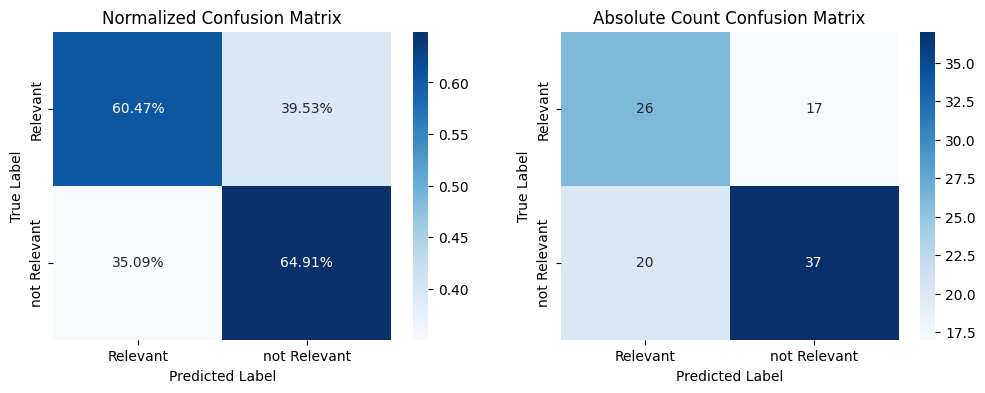

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Convert boolean values in y_true to string values that match those in y_pred
y_true = df['is_relevant'].map({True: 'Relevant', False: 'not Relevant'})

# Convert boolean values in y_pred to string values that match those in y_true
y_pred = df['label'].map({True: 'Relevant', False: 'not Relevant'})

# Compute confusion matrix
conf_mat = confusion_matrix(y_true, y_pred, labels=['Relevant', 'not Relevant'])

# Normalize confusion matrix
conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

# Create subplots for two confusion matrices
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Generate heatmap plot with annotations for normalized confusion matrix
sns.heatmap(conf_mat_norm, annot=True, fmt='.2%', cmap='Blues', ax=axes[0])

# Add axis labels and title for normalized confusion matrix
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title('Normalized Confusion Matrix')

# Add class names to axis ticks
axes[0].xaxis.set_ticklabels(['Relevant', 'not Relevant'])
axes[0].yaxis.set_ticklabels(['Relevant', 'not Relevant'])

# Generate heatmap plot with annotations for absolute count confusion matrix
sns.heatmap(conf_mat, annot=True, cmap='Blues', ax=axes[1])

# Add axis labels and title for absolute count confusion matrix
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_title('Absolute Count Confusion Matrix')

# Add class names to axis ticks
axes[1].xaxis.set_ticklabels(['Relevant', 'not Relevant'])
axes[1].yaxis.set_ticklabels(['Relevant', 'not Relevant'])

# Show plot
plt.show()

In [50]:
from sklearn.metrics import accuracy_score, f1_score
# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
# Calculate F1-score
f1 = f1_score(y_true, y_pred, pos_label='Relevant')
# Show accuracy and F1-score
print("Accuracy:", accuracy)
print("F1-score:", f1)

Accuracy: 0.63
F1-score: 0.5842696629213482
